# Predição de CRA com Regressão

Brunna de Sousa Pereira Amorim

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline


## Dados

In [113]:
treino = pd.read_csv("treino.csv")
treino.head()

,matricula,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra,Cálculo1
0,0cc3d63edf0b986cb87e345972857e15,8.6,10.0,9.0,9.1,8.6,8.4,8.3,8.8,8.2,7.9,9.4,8.477647,8.7
1,0d78246db769dc958ce19fc414050b2a,5.6,7.0,7.7,7.0,8.1,6.2,7.3,8.2,5.4,7.7,8.9,6.851724,7.0
2,0f5bb983df06b90337dc2c6301fef3f6,10.0,9.8,7.9,9.6,8.3,8.7,8.8,9.5,9.2,8.6,9.7,9.090588,8.6
3,1307a4421a67a497cea198e8ccfb97ee,6.1,8.3,6.8,8.2,7.1,8.0,6.3,8.9,7.0,8.5,9.0,7.283516,7.8
4,1432d50cf8519694ab992c414d90a130,8.8,9.3,5.0,8.5,5.1,5.0,5.8,7.1,5.4,8.7,8.2,7.205747,5.2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000016D06A20>]], dtype=object)

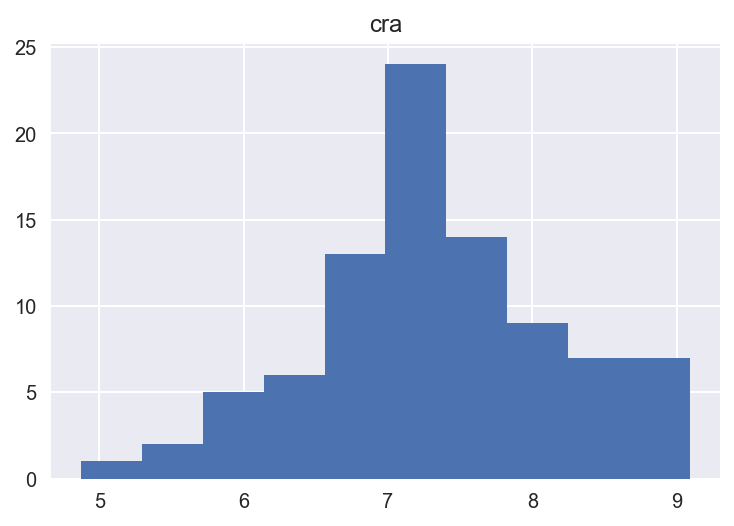

In [114]:
pd.DataFrame(treino.cra).hist()

In [115]:
X_train = treino.drop(['matricula', 'cra'], 1)
X_test = treino[treino.shape[0]:]
y = treino.cra

## Modelos

### Regressão usando Ridge 

In [116]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

modeloRidge = Ridge()

#### Tunando hiperâmetros 

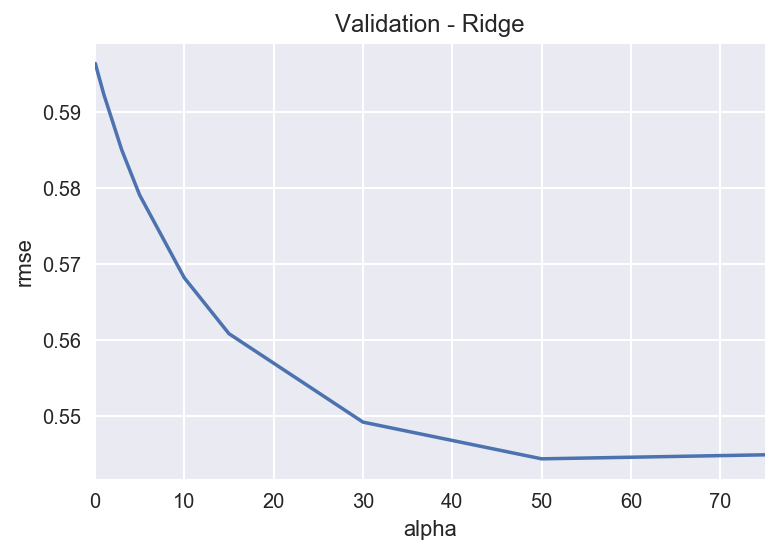

In [117]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvRidge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cvRidge = pd.Series(cvRidge, index = alphas)
cvRidge.plot(title = "Validation - Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")


In [118]:
cvRidge

0.05     0.596405
0.10     0.596178
0.30     0.595282
1.00     0.592312
3.00     0.585016
5.00     0.579084
10.00    0.568183
15.00    0.560822
30.00    0.549177
50.00    0.544341
75.00    0.544870
dtype: float64

De acordo com o gráfico, o melhor valor para alpha é 50

Então, vamos usá-lo para treinar o modelo.

#### Modelo Ridge

In [119]:
modeloRidge = Ridge(alpha = 50)
modeloRidge.fit(X_train, y)

print("Coeficientes do modelo Ridge: {0}".format(modeloRidge.coef_))

Coeficientes do modelo Ridge: [ 0.08523772  0.01124902  0.02190341  0.07574798  0.03119681 -0.02196576
  0.14645939  0.1248893   0.14459121  0.0475632   0.00573308  0.0262821 ]


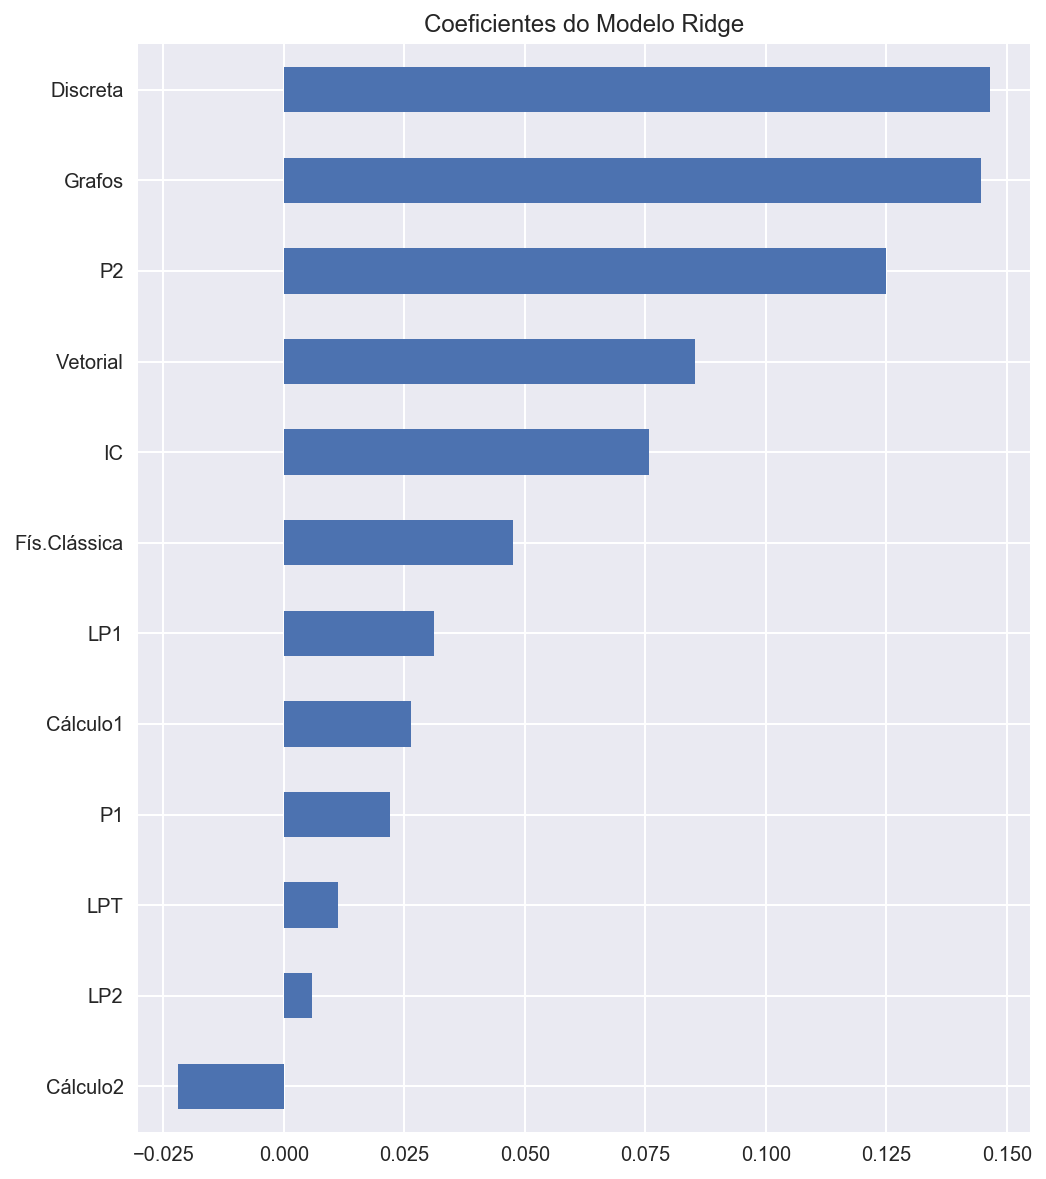

In [120]:
coefRidge = pd.Series(modeloRidge.coef_, index = X_train.columns)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coefRidge.sort_values().plot(kind = "barh")
plt.title("Coeficientes do Modelo Ridge")

#### Predição e Resíduos

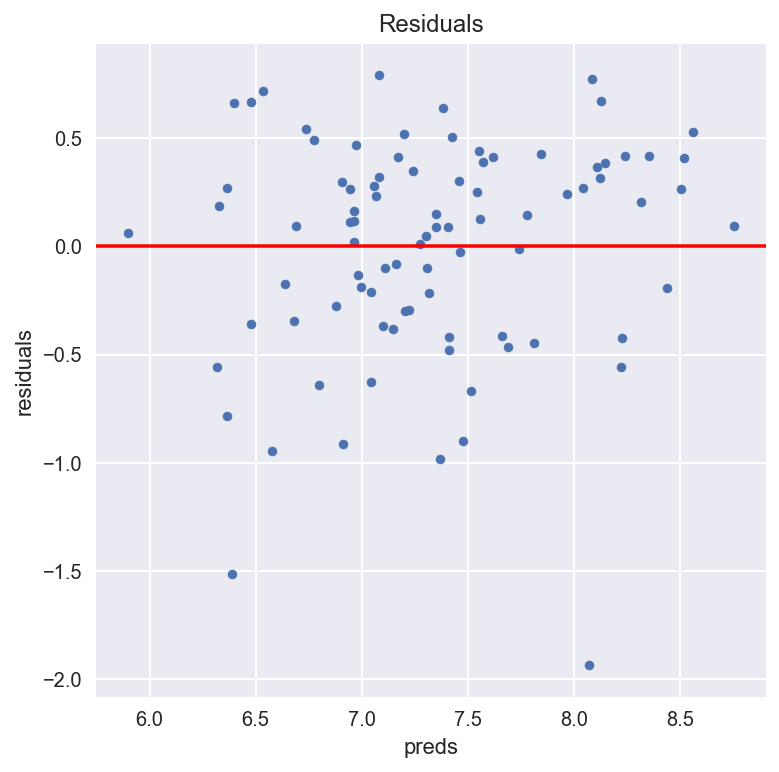

In [121]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

predsRidge = pd.DataFrame({"preds":modeloRidge.predict(X_train), "true":y})
predsRidge["residuals"] = predsRidge["true"] - predsRidge["preds"]
predsRidge.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Regressão usando Lasso

#### Tunando hiperâmetros

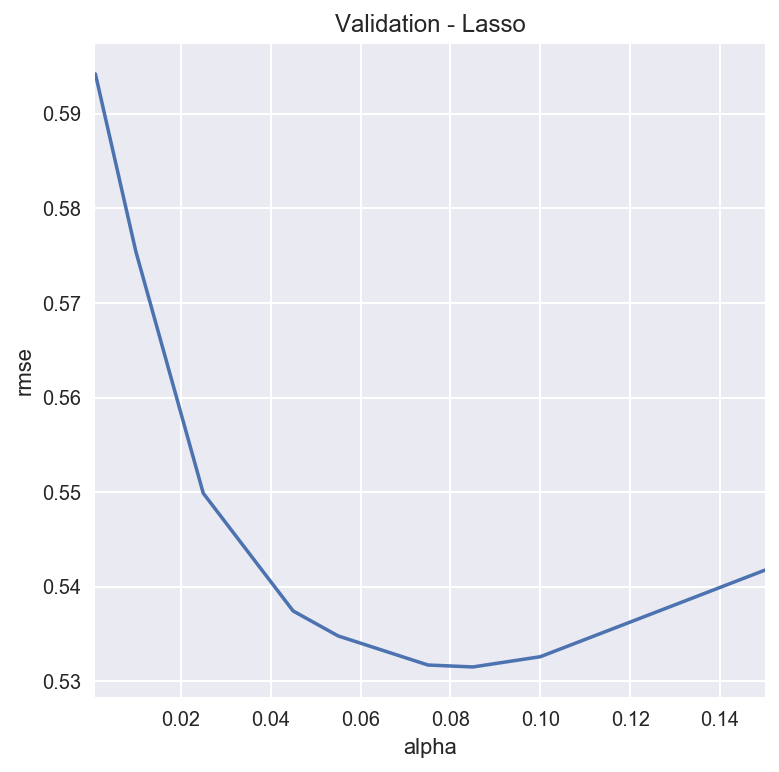

In [122]:
alphasLasso = [0.001, 0.01, 0.025, 0.045, 0.055, 0.075, 0.085, 0.1, 0.15]

cvLasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphasLasso]

cvLasso = pd.Series(cvLasso, index = alphasLasso)
cvLasso.plot(title = "Validation - Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [123]:
cvLasso

0.001    0.594216
0.010    0.575448
0.025    0.549889
0.045    0.537442
0.055    0.534806
0.075    0.531728
0.085    0.531524
0.100    0.532605
0.150    0.541763
dtype: float64

Então, como podemos ver no gráfico, o melhor valor de alpha é 0.085

#### Modelo Lasso

In [124]:
modeloLasso = Lasso(alpha = 0.085)
modeloLasso.fit(X_train, y)

print("Coeficientes do modelo Lasso: {0}".format(modeloLasso.coef_))

Coeficientes do modelo Lasso: [ 0.07292627  0.          0.          0.03264498  0.         -0.
  0.17489322  0.14576019  0.18565219  0.          0.          0.        ]


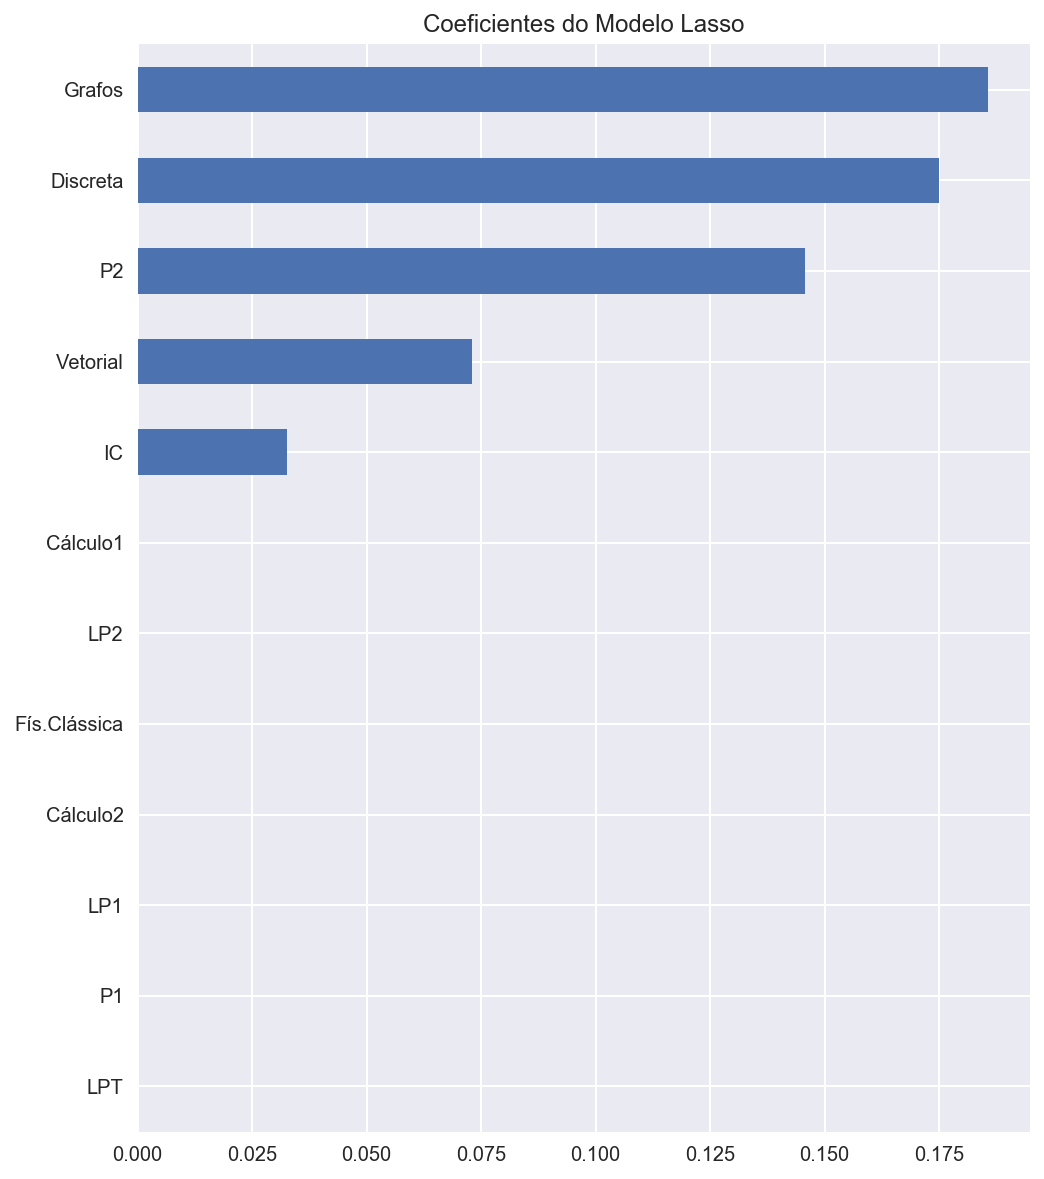

In [125]:
coefLasso = pd.Series(modeloLasso.coef_, index = X_train.columns)

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coefLasso.sort_values().plot(kind = "barh")
plt.title("Coeficientes do Modelo Lasso")

#### Predição e Resíduos

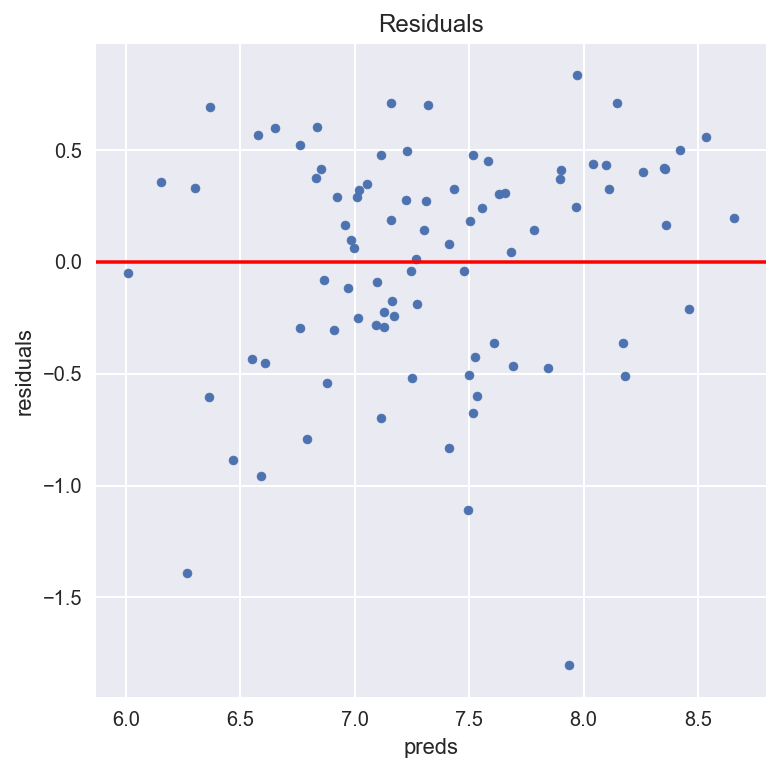

In [126]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

predsLasso = pd.DataFrame({"preds":modeloLasso.predict(X_train), "true":y})
predsLasso["residuals"] = predsLasso["true"] - predsLasso["preds"]
predsLasso.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Regressão com Kernel Regression

#### Tunando hiperâmetros

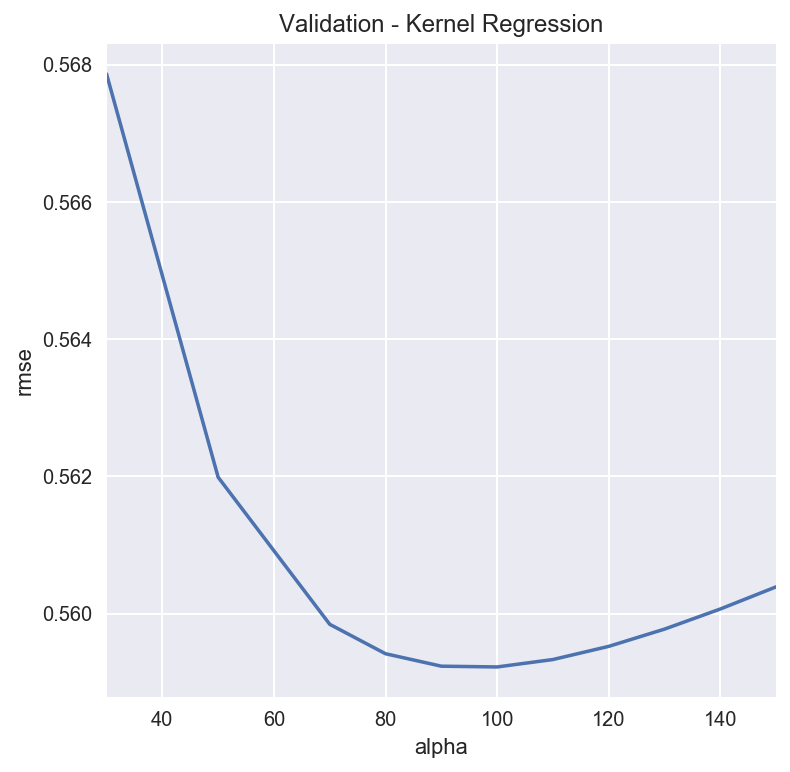

In [127]:
alphasKR = [30, 50, 70, 80, 90, 100, 110, 120, 130, 140, 150]
cvKernel = [rmse_cv(KernelRidge(alpha = alpha)).mean() 
            for alpha in alphasKR]


cvKernel = pd.Series(cvKernel, index = alphasKR)
cvKernel.plot(title = "Validation - Kernel Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [128]:
cvKernel

30     0.567868
50     0.561990
70     0.559846
80     0.559417
90     0.559235
100    0.559224
110    0.559332
120    0.559524
130    0.559776
140    0.560069
150    0.560392
dtype: float64

Então, como podemos ver, o melhor alpha para o Kernel Regression é 100

#### Modelo Kernel Regression

In [129]:
modeloKernel = KernelRidge(alpha = 100)
modeloKernel.fit(X_train, y)

KernelRidge(alpha=100, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

#### Predição e Resíduos

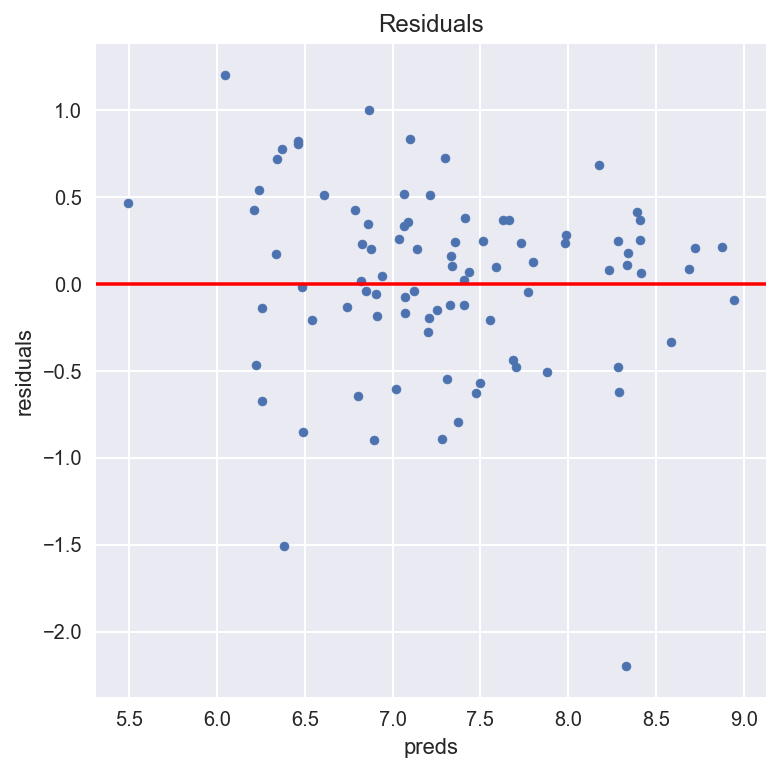

In [130]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

predsKernel = pd.DataFrame({"preds":modeloKernel.predict(X_train), "true":y})
predsKernel["residuals"] = predsKernel["true"] - predsKernel["preds"]
predsKernel.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

### Regressão com KNN

#### Tunando hiperâmetros

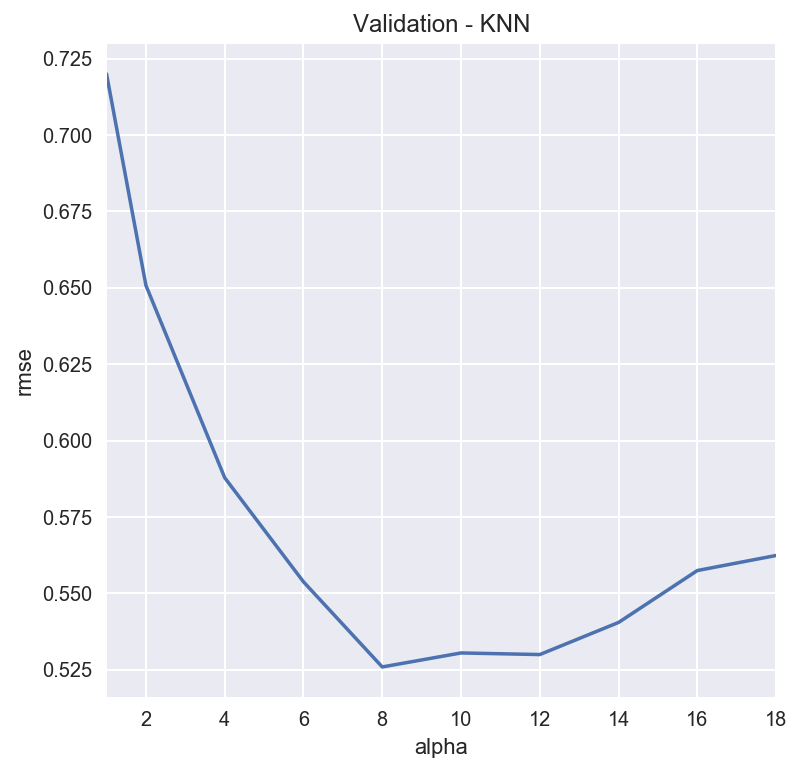

In [131]:
alphasKNN = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18]
cvKNN = [rmse_cv(KNeighborsRegressor(n_neighbors = alpha)).mean() 
            for alpha in alphasKNN]


cvKNN = pd.Series(cvKNN, index = alphasKNN)
cvKNN.plot(title = "Validation - KNN")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [132]:
cvKNN

1     0.719987
2     0.650804
4     0.587855
6     0.553789
8     0.525923
10    0.530503
12    0.529978
14    0.540486
16    0.557475
18    0.562399
dtype: float64

Então, como podemos verificar pelo gráfico, o melhor alpha é 8.

#### Modelo KNN

In [133]:
modeloKNN = KNeighborsRegressor(n_neighbors = 8)
modeloKNN.fit(X_train, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=8, p=2,
          weights='uniform')

#### Predição e Resíduos

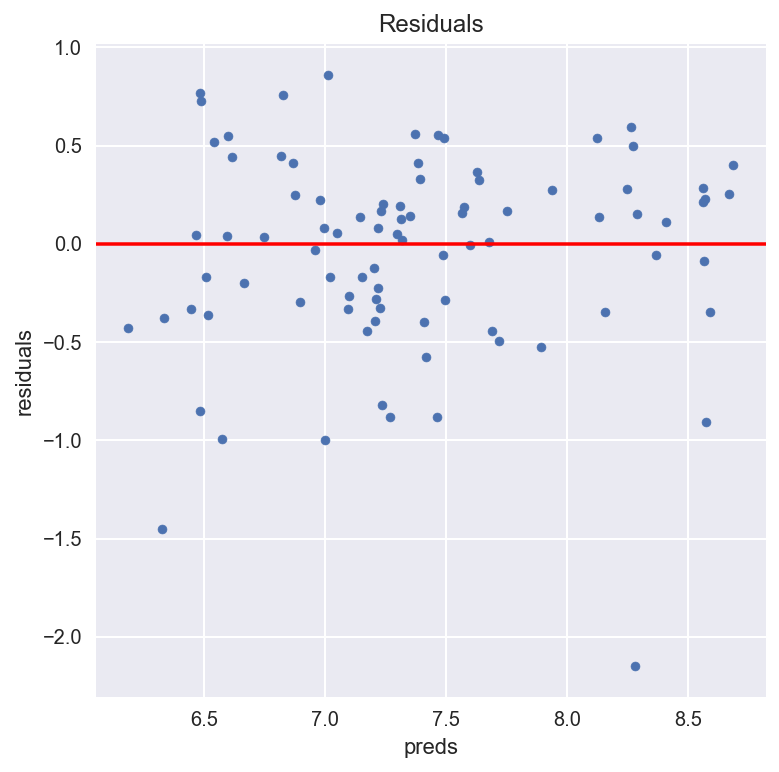

In [134]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

predsKNN = pd.DataFrame({"preds":modeloKNN.predict(X_train), "true":y})
predsKNN["residuals"] = predsKNN["true"] - predsKNN["preds"]
predsKNN.plot(x = "preds", y = "residuals",kind = "scatter", title="Residuals")
plt.axhline(0, color='red')

## RMSEs da validação cruzada

Usando a validação cruzada, tivemos os seguintes resultados para os modelos utilizados:

In [135]:
print("RMSE validação cruzada - Ridge: {0}".format(cvRidge.min()))
print("RMSE validação cruzada - Lasso: {0}".format(cvLasso.min()))
print("RMSE validação cruzada - Kernel Regression: {0}".format(cvKernel.min()))
print("RMSE validação cruzada - KNN: {0}".format(cvKNN.min()))

RMSE validação cruzada - Ridge: 0.54434129997
RMSE validação cruzada - Lasso: 0.531523906026
RMSE validação cruzada - Kernel Regression: 0.559224127752
RMSE validação cruzada - KNN: 0.525922691034


## Avaliando modelos com os dados de teste

Agora, usando os dados de teste real, vamos re-treinar o melhor modelo sem validação cruzada. Nesse caso, o melhor modelo foi o KNN.

In [136]:
teste = pd.read_csv("teste.csv")
teste.head()

,matricula,Cálculo1,Vetorial,LPT,P1,IC,LP1,Cálculo2,Discreta,P2,Grafos,Fís.Clássica,LP2,cra
0,066a1b8f51616bc9f7cf392aec12df2c,7.0,7.0,5.2,5.4,7.9,6.4,5.0,5.1,6.4,7.1,7.0,7.1,6.790805
1,07e605cabb25fcd348569d15324433cc,7.0,7.0,7.2,7.9,8.7,7.7,6.5,7.9,8.7,6.5,7.2,9.0,7.230337
2,1298de387b2af5489ce432fe854ae0f7,7.3,5.0,8.3,8.1,7.0,7.4,5.0,5.9,7.3,5.6,5.0,7.1,6.873626
3,1471a43df7d59a219ad739462d791410,7.0,6.8,6.4,7.0,8.6,8.2,6.3,8.0,7.9,5.4,9.0,8.9,7.444828
4,25f50af45fa0065a73077d8d047a7cd1,7.8,7.4,7.0,7.0,8.7,7.1,7.3,8.2,8.1,7.5,7.4,8.0,7.954118


In [137]:
x_teste = teste.drop(['matricula', 'cra'], 1)
y_teste = teste.cra

rmseKNN = np.sqrt(mean_squared_error(y_teste, modeloKNN.predict(x_teste)))
print("RMSE - KNN: {0}".format(rmseKNN))

RMSE - KNN: 0.441324312694


Para os outros modelos, sem a validação cruzada, temos:

In [138]:
rmseRidge = np.sqrt(mean_squared_error(y_teste, modeloRidge.predict(x_teste)))
rmseLasso = np.sqrt(mean_squared_error(y_teste, modeloLasso.predict(x_teste)))
rmseKernel = np.sqrt(mean_squared_error(y_teste, modeloKernel.predict(x_teste)))

print("RMSE - Ridge: {0}".format(rmseRidge))
print("RMSE - Lasso: {0}".format(rmseLasso))
print("RMSE - Kernel: {0}".format(rmseKernel))

RMSE - Ridge: 0.367126043725
RMSE - Lasso: 0.380253959548
RMSE - Kernel: 0.489855106558
